In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from molecular_simulations.utils import writeXYZ

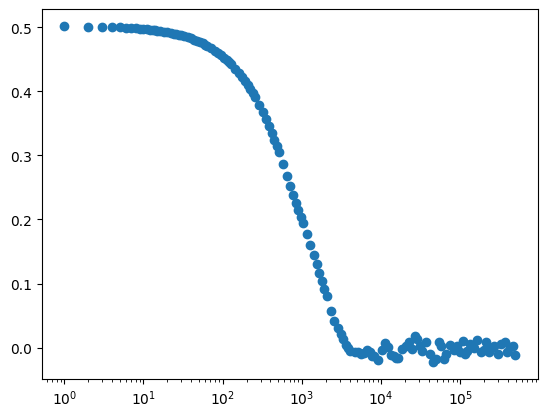

In [266]:

class Correlator:
    def __init__(self, steps: int) -> None:
        self.block_p = 16
        self.block_m = 2
        self.ratio  = int(self.block_p / self.block_m)
        if steps < self.block_m:
            self.max_block_operations_ = 1
        else:
            self.max_block_operations_ = (
                int(np.floor(np.emath.logn(self.block_m, steps))) + 1
            )
        # Floating point can hit hard on logn
        if self.block_m**self.max_block_operations_ == steps:
            self.max_block_operations_ += 1
        self.powers = np.array([0, 1, 2], dtype=int)
        self.reset()


    def reset(self):
        self.block_counts_ = np.zeros(shape=(self.max_block_operations_,),dtype=int)
        self.block_size_= np.array([self.block_m**i for i in range(self.max_block_operations_)],dtype=int)
        self.data_ = np.zeros(shape=(self.max_block_operations_, self.block_p),dtype=float)
        self.correlator_ = np.zeros(shape=(self.max_block_operations_, self.block_p),dtype=float)
        self.accumulator_ = np.zeros(shape=(self.max_block_operations_,),dtype=float)
    
    def _update_data(self, value: float,  i: int = 0):
        # Update data level i
        # Push value to the first place in the array
        # Shift all the others
        self.data_[i, 1:] = self.data_[i, :-1]
        self.data_[i, 0] = value
    
    def _update_lowest_correlator(self):
        # Perform correlation between first data point
        # and the rest of the array
        self.correlator_[0] += self.data_[0,0] * self.data_[0]

    def _update_correlator(self, i: int = 1):
        # Perform correlation between first data point
        # and the rest of the array
        # Only update after 'ratio'
        self.correlator_[i,self.ratio:] += self.data_[i,0] * self.data_[i, self.ratio:]


    def accumulate(self,value:float):
        # Update count of the lowest level and accumulator
        # (which corresponds to the overall counter)
        self.block_counts_[0] += 1
        self.accumulator_[0] += value
        # Update data, correlator of the lowest block
        self._update_data(value)
        self._update_lowest_correlator()
        
        # Accumulate higher blocks with the new value
        update_i = np.argmax(self.count() % self.block_size_[::-1] == 0)
        for i in range(1,self.max_block_operations_ - update_i):
            # The new value is the averaged cumulative sum of the previous level
            value = self.accumulator_[i-1] / self.block_m
            # Reset old accumulator
            self.accumulator_[i-1] = 0
            # Update count and accumulator of new level
            self.block_counts_[i] += 1
            self.accumulator_[i] += value
            # Update data, correlator of the new block
            self._update_data(value,i)
            self._update_correlator(i)

    def count(self, i: int = 0) -> int:
        return self.block_counts_[i]
    

    def _rebuild_levels(self, correlator: np.ndarray):
        # Rebuild all the levels
        # The correlator is complete until the level count is > p
        level_mask = self.block_counts_>= self.block_p
        # Create 2D array of counter
        # For each row:
        # n_ij = block_count_i - j, j = 0...(block_p - 1)
        n = self.block_counts_[level_mask, None] - np.arange(self.block_p)
        # Exclude last level
        res = correlator[level_mask] / n
        # Create 2D array of time
        # For each row:
        # t_ij = block_size * j, j = 0...(block_n - 2)
        t = (self.block_size_[level_mask, None] * np.arange(self.block_p))
        # Mask valid times
        mask = np.ones(shape=res.shape, dtype=int)
        # From the second row onward, mask until the ratio element
        mask[1:,:self.ratio] = 0
        return t[mask==1], res[mask==1]


    def acf(self) -> np.ndarray:
        # Return the autocorrelation function
        t, res = self._rebuild_levels(self.correlator_)
        return np.column_stack((t, res))
    

class NCorrelator(Correlator):
    def __init__(self, steps: int, N: int) -> None:
        super().__init__(steps)
        self.N = N
        self.data_ = np.zeros(shape=(self.max_block_operations_, self.block_p, N),dtype=float)
        self.accumulator_ = np.zeros(shape=(self.max_block_operations_, N),dtype=float)
    
    def _update_data(self, value: np.ndarray,  i: int = 0):
        # Update data level i
        # Push value to the first place in the array
        # Shift all the others
        self.data_[i, 1:,:] = self.data_[i, :-1,:]
        self.data_[i, 0,:] = value
    
    def _update_lowest_correlator(self):
        # Perform correlation between first data point
        # and the rest of the array
        self.correlator_[0] += np.matmul(self.data_[0,:,:], self.data_[0,0,:])

    def _update_correlator(self, i: int = 1):
        # Perform correlation between first data point
        # and the rest of the array
        # Only update after 'ratio'
        self.correlator_[i,self.ratio:] += np.matmul(self.data_[i, self.ratio:,:],self.data_[i,0,:])
    

    def accumulate(self,value:np.ndarray):
        # Update count of the lowest level and accumulator
        # (which corresponds to the overall counter)
        self.block_counts_[0] += 1
        self.accumulator_[0,:] += value
        # Update data, correlator of the lowest block
        self._update_data(value)
        self._update_lowest_correlator()
        
        # Accumulate higher blocks with the new value
        update_i = np.argmax(self.count() % self.block_size_[::-1] == 0)
        for i in range(1,self.max_block_operations_ - update_i):
            # The new value is the averaged cumulative sum of the previous level
            value = self.accumulator_[i-1] / self.block_m
            # Reset old accumulator
            self.accumulator_[i-1, :] = 0
            # Update count and accumulator of new level
            self.block_counts_[i] += 1
            self.accumulator_[i,:] += value
            # Update data, correlator of the new block
            self._update_data(value,i)
            self._update_correlator(i)
        
    def acf(self) -> np.ndarray:
        # Return the autocorrelation function
        t, res = self._rebuild_levels(self.correlator_)
        return np.column_stack((t, res/self.N))

class MSDNCorrelator(NCorrelator):
    def __init__(self, steps: int, N: int) -> None:
        super().__init__(steps, N)
        self.msd_correlator_ = np.zeros(shape=(self.max_block_operations_, N),dtype=float)


    def _update_lowest_correlator(self):
        super()._update_lowest_correlator()
        # Perform correlation between first data point
        # and the rest of the array
        dim = min(self.count(), self.block_p)
        self.msd_correlator_[0,:dim] += np.matmul(self.data_[0,:dim,:].cumsum(axis=1), self.data_[0,0,:])

    def _update_correlator(self, i: int = 1):
        super()._update_correlator(i)
        # Perform correlation between first data point
        # and the rest of the array
        # Only update after 'ratio'
        dim = min(self.count(i), self.block_p)
        self.msd_correlator_[i,self.ratio:dim] += np.matmul(self.data_[i, self.ratio:dim,:],self.data_[i,0,:])
        
    def msd(self) -> np.ndarray:
        # Return the autocorrelation function
        t, res = self._rebuild_levels(self.msd_correlator_)
        return np.column_stack((t, res))

class DNCorrelator:
    def __init__(self, steps: int, N: int, dim: int = 3) -> None:
        self.steps = steps
        self.N = N
        self.d = dim
        self.x_corr = NCorrelator(self.steps,self.N)
        self.y_corr = NCorrelator(self.steps,self.N)
        self.z_corr = NCorrelator(self.steps,self.N)
    
    def accumulate(self, value: np.ndarray):
        self.x_corr.accumulate(value[:,0])
        self.y_corr.accumulate(value[:,1])
        self.z_corr.accumulate(value[:,2])
    
    def acf(self) -> np.ndarray:
        # Return the autocorrelation function
        res_x = self.x_corr.acf()
        res_y = self.y_corr.acf()
        res_z = self.z_corr.acf()
        return np.column_stack((res_x[:,0],(res_x[:,1] + res_y[:,1] + res_z[:,1])))


class MSDCorrelator(Correlator):
    def __init__(self, steps: int) -> None:
        super().__init__(steps)
        self.msd_correlator_ = np.zeros(shape=(self.max_block_operations_, self.block_p),dtype=float)


    def _update_data(self, value: float,  i: int = 0):
        # Update data level i
        # Push value to the first place in the array
        # Shift all the others
        self.data_[i, 1:] = self.data_[i, :-1]
        self.data_[i, 0] = self.block_value



    def accumulate(self,value:float):
        # Update count of the lowest level and accumulator
        # (which corresponds to the overall counter)
        self.block_counts_[0] += 1
        self.accumulator_[0] += value
        # Update data, correlator of the lowest block
        self._update_data(value)
        self._update_lowest_correlator()
        
        # Accumulate higher blocks with the new value
        update_i = np.argmax(self.count() % self.block_size_[::-1] == 0)
        for i in range(1,self.max_block_operations_ - update_i):
            # The new value is the averaged cumulative sum of the previous level
            value = self.accumulator_[i-1] / self.block_m
            # Reset old accumulator
            self.accumulator_[i-1] = 0
            # Update count and accumulator of new level
            self.block_counts_[i] += 1
            self.accumulator_[i] += value
            # Update data, correlator of the new block
            self._update_data(value,i)
            self._update_correlator(i)

    def count(self, i: int = 0) -> int:
        return self.block_counts_[i]
    

    def _rebuild_levels(self, correlator: np.ndarray):
        # Rebuild all the levels
        # The correlator is complete until the level count is > p
        level_mask = self.block_counts_>= self.block_p
        # Create 2D array of counter
        # For each row:
        # n_ij = block_count_i - j, j = 0...(block_p - 1)
        n = self.block_counts_[level_mask, None] - np.arange(self.block_p)
        # Exclude last level
        res = correlator[level_mask] / n
        # Create 2D array of time
        # For each row:
        # t_ij = block_size * j, j = 0...(block_n - 2)
        t = (self.block_size_[level_mask, None] * np.arange(self.block_p))
        # Mask valid times
        mask = np.ones(shape=res.shape, dtype=int)
        # From the second row onward, mask until the ratio element
        mask[1:,:self.ratio] = 0
        return t[mask==1], res[mask==1]


    def acf(self) -> np.ndarray:
        # Return the autocorrelation function
        t, res = self._rebuild_levels(self.correlator_)
        return np.column_stack((t, res))

    def _update_lowest_correlator(self):
        super()._update_lowest_correlator()
        # Perform correlation between first data point
        # and the rest of the array
        dim = min(self.count(), self.block_p)
        self.msd_correlator_[0,:dim] += (self.data_[0,:dim]).cumsum() ** 2

    def _update_correlator(self, i: int = 1):
        super()._update_correlator(i)
        # Perform correlation between first data point
        # and the rest of the array
        # Only update after 'ratio'
        dim = min(self.count(i), self.block_p)
        self.msd_correlator_[i,self.ratio:dim] += (self.block_m * self.data_[i, self.ratio:dim]).cumsum() ** 2
    
    
    def msd(self) -> np.ndarray:
        # Return the autocorrelation function
        t, res = self._rebuild_levels(self.msd_correlator_)
        return np.column_stack((t, res))

data = np.random.normal(size=(10**6,))
acc = MSDCorrelator(len(data))
x = 0
for i, w in enumerate(data):
    x += -x * .001 + np.sqrt(.001) * w
    acc.accumulate(x)

acf = acc.acf()
plt.plot(acf[:,0], acf[:,1], 'o')
plt.xscale('log')

In [267]:
acc.msd_correlator_

array([[5.01885145e+05, 2.00653879e+06, 4.51296067e+06, 8.02015012e+06,
        1.25271048e+07, 1.80328224e+07, 2.45363026e+07, 3.20365463e+07,
        4.05325545e+07, 5.00233278e+07, 6.05078669e+07, 7.19851733e+07,
        8.44542493e+07, 9.79141002e+07, 1.12363733e+08, 1.27802155e+08],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00325639e+06, 4.01002333e+06, 9.01629451e+06, 1.60180634e+07,
        2.50113322e+07, 3.59921044e+07, 4.89563887e+07, 6.39002078e+07],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.01245858e+05, 2.00223031e+06, 4.49895595e+06, 7.98743318e+06,
        1.24636927e+07, 1.79237981e+07, 2.43638281e+07, 3.17798792e+07],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000

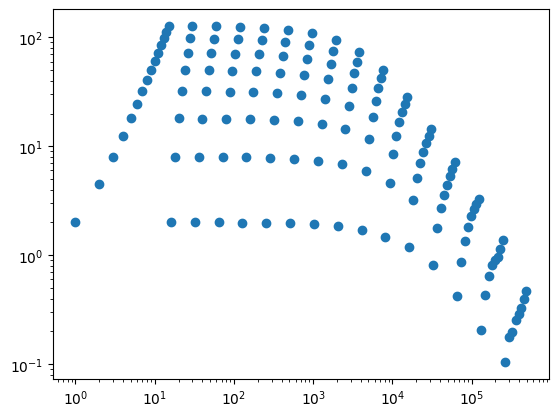

In [268]:
msd = acc.msd()
plt.plot(msd[:,0], msd[:,1], 'o')
plt.xscale('log')
plt.yscale('log')

In [216]:
from typing import Tuple

import numpy as np
from numba import njit

from molecular_simulations.utils import (
    dist,
    initialise_lattice,
    initialise_velocities,
    Accumulator
)


def lj_md(
    N: int,
    rho: float,
    T: float,
    dt: float,
    eqnum: int = 100,  # Equilibration steps
    snum: int = 1000,  # Sampling steps
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    np.random.seed(42)
    # Reduced units:
    # epsilon (energy)
    # sigma (length)
    # m (mass)

    # U* = U * epsilon
    # T* = kb * T / epsilon
    # P* = P * sigma^3 / epsilon
    # rho* = rho * sigma^3

    V = N / rho
    L = V ** (1 / 3)
    cutoff = 2.5  # cutoff
    cutoff_sq = cutoff**2
    # Tail of the energy contribution due to truncation
    tail_e = (1 / cutoff_sq) ** 6 - (1 / cutoff_sq) ** 3

    @njit
    def single_force(
        dists: np.ndarray,
        delta_pos: np.ndarray,
        forces: np.ndarray,
    ) -> Tuple[float, np.ndarray]:
        # Apply cutoff as boolean mask & calculate all single energy contributions
        rc = dists < cutoff_sq
        r2 = 1 / dists[rc]
        r6 = r2**3
        en = r6 * (r6 - 1)
        vir = r6 * (r6 - 0.5)
        term = r2 * vir
        ff = (
            delta_pos[rc] * term[:, None]
        )  # Forces on particle i by all remaining pairs
        forces[rc] -= ff  # Substract ff to the forces array (3rd law)

        return en.sum() - tail_e * rc.sum(), vir.sum(), ff.sum(axis=0)

    @njit
    def update_forces(positions: np.ndarray, forces: np.ndarray) -> float:
        en = 0
        vir = 0
        forces[:] = 0
        for i in range(N - 1):
            # Calculate the force on particle i (and the energy)
            particle = positions[i]
            delta_pos, dists = dist(positions[i + 1 :], particle, L)
            eni, viri, fi = single_force(dists, delta_pos, forces[i + 1 :])
            # Update energy and forces
            en += eni
            vir += viri
            forces[i] += fi
        return en, vir

    def integrate(
        positions: np.ndarray,
        positions_o: np.ndarray,
        velocities: np.ndarray,
        forces: np.ndarray,
    ):
        positions_n = 2 * positions - positions_o + dt**2 * 48 * forces  # Verlet
        velocities[:] = (positions_n - positions_o) / (2 * dt)  # Velocity
        # Update
        positions_o[:] = positions[:]
        positions[:] = positions_n[:]

    def md_loop(
        positions: np.ndarray,
        positions_o: np.ndarray,
        velocities: np.ndarray,
        forces: np.ndarray,
    ) -> Tuple[float, float]:
        en, vir = update_forces(positions, forces)
        integrate(positions, positions_o, velocities, forces)
        v_sq = (velocities**2).sum() / N
        return en, vir, v_sq

    def eq_run():
        for i in range(eqnum):
            en, _, v_sq = md_loop(positions, positions_o, velocities, forces)
            k = v_sq / 2
            u = 4 * en / N

            if (i + 1) % 100 == 0:
                print(
                    "\rStep: {0}/{1} Energy: {2:.6f} U: {3:.6f} K: {4:.6f}".format(
                        i + 1, eqnum, u + v_sq / 2, u, k
                    ),
                    end="\r",
                )

    def prod_run():
        for i in range(snum):
            en, vir, v_sq = md_loop(positions, positions_o, velocities, forces)
            acc_u.accumulate(4 * en / N)
            acc_k.accumulate(v_sq / 2)
            acc_p.accumulate(48*vir/(3*V) + rho * v_sq / 3)
            corr_v.accumulate(velocities)

            if (i + 1) % 1000 == 0:
                print(
                    "Step: {0}/{1} Energy: {2:.6f} U: {3:.6f} K: {4:.6f}".format(
                        i + 1, snum, 4 * en / N + v_sq / 2, 4 * en / N, v_sq / 2
                    ),
                    end="\r",
                )

    # Tracking arrays
    positions = initialise_lattice(N, L)
    velocities = initialise_velocities(N, T)
    forces = np.zeros(shape=(N, 3))
    positions_o = positions - velocities * dt
    eq_run()

    corr_v = DNCorrelator(snum,N,dim=3)
    acc_u = Accumulator(snum)
    acc_k = Accumulator(snum)
    acc_p = Accumulator(snum)
    prod_run()
    return positions, velocities, forces, acc_u, acc_k, acc_p, corr_v


In [217]:
N = 108
rho = 0.8442
T = 0.728
delta = 0.001
pos, vel, forc, acc_u, acc_k, acc_p, corr_v = lj_md(N, rho, T, delta, eqnum=2500, snum=600000)

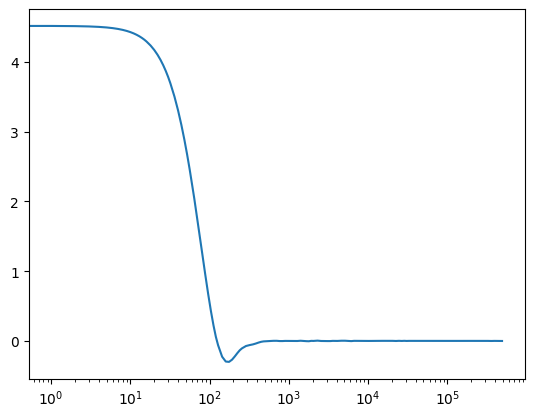

In [245]:
vacf = corr_v.acf()
t_delta = vacf[:,0] < np.inf
plt.plot(vacf[t_delta,0], vacf[t_delta, 1])
plt.xscale('log')

<ErrorbarContainer object of 3 artists>

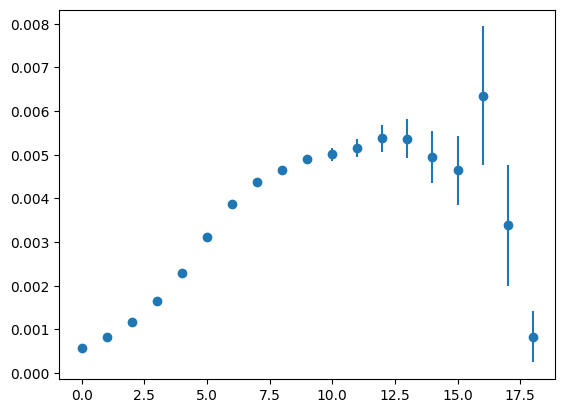

In [242]:
var_est, var_err = acc_p.block_vars_est()
plt.errorbar(np.arange(len(var_est)),np.sqrt(var_est), yerr=var_err/(2*var_est)*np.sqrt(var_est), fmt='o')

In [220]:
u_st, _ = acc_u.uncorr_stdev()
k_st, _ = acc_k.uncorr_stdev()
p_st, _ = acc_p.uncorr_stdev()
print(acc_u.mean(), np.sqrt(u_st))
print(acc_k.mean(), np.sqrt(k_st))
print(acc_p.mean(), np.sqrt(p_st))

-4.420307225246392 0.0010847285461747312
2.2569380597572835 0.0009789267771797099
5.177455476110827 0.0008263190978296626
